In [1]:
import backtrader as bt
#import matplotlib.pyplot as plt
import backtrader.indicators as btind

import numpy as np
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import math
from sklearn import preprocessing
from math import sqrt
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.constraints import max_norm
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
from keras.losses import binary_crossentropy,mean_squared_error
from keras.models import model_from_json

from technicalSignals import momentum,SMA,inBBands

#CPU RUN
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/simone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']
TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
TREND_WINDOWs = [(1,50)]
kind_of_dataset = 'Summary'
NN_INPUT_DIM = 65

In [3]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = momentum(price, 30)
            price['mom_50'] = momentum(price, 50)
            price['mom_100'] = momentum(price, 100)
            price['mom_150'] = momentum(price, 150)
            price['SMA_30'] = SMA(price, 30)
            price['SMA_50'] = SMA(price, 50)
            price['SMA_100'] = SMA(price, 100)
            price['SMA_150'] = SMA(price, 150)
            price['in_BBands'] = inBBands(price)

        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 20, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150','SMA_30','SMA_50','SMA_100','SMA_150','in_BBands']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            s =np.sign(cumulative_return)
            y.append(0 if s==-1 else 1)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])

        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test

In [4]:
def weighted_MSE(y_true, y_pred):
    weights = K.pow(y_true,2)
    m = K.min(weights)
    M = K.max(weights)
    weights = (weights-m)/(M-m)
    return mean_squared_error(y_true,y_pred)*weights

def buildNN2(n_expected_active_units, dropout = 0.5, max_norm_val = 3.0):
    #dropout is the probability of retaining a unit (contrary of paper)
    n_units = math.floor(n_expected_active_units / (1 - dropout))
    model = Sequential()  
    model.add(Dense(n_units, input_dim=NN_INPUT_DIM, kernel_constraint=max_norm(max_norm_val), trainable=False)) #Linear activ. funct Wx+b
    model.add(BatchNormalization(trainable=False)) # Batch norm applied only on the part without activation (done more often)
    model.add(LeakyReLU(trainable=False)) # ReLU can be less sensible to noise? there is an entire area in which the output is 0
    model.add(Dropout(dropout, trainable=False))
    model.add(Dense(math.floor(n_units/2), kernel_constraint=max_norm(max_norm_val), trainable=False)) 
    model.add(BatchNormalization(trainable=False)) 
    model.add(LeakyReLU(trainable=False))
    model.add(Dropout(dropout, trainable=False))
    model.add(Dense(math.floor(n_units/4), kernel_constraint=max_norm(max_norm_val), trainable=False)) 
    model.add(BatchNormalization(trainable=False)) 
    model.add(LeakyReLU(trainable=False)) 
    model.add(Dense(1, activation='tanh')) 
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,loss='mse', metrics=[weighted_MSE])
    return model

def cv(x_tv,y_tv):
    best_mcc = -float(np.inf)
    best_c = 0
    best_g = 0
    for c in np.logspace(-3,4,10):
        for g in np.logspace(-3,4,10):
            print('.', end='')
            trainpoint=math.floor(len(x_tv)*0.50)
            dimval=math.floor(trainpoint*0.25)
            endval=trainpoint+dimval
            #Cross validation
            cvMCC = 0
            for i in range(0,4):
                x_train=x_tv[0:trainpoint]
                y_train=y_tv[0:trainpoint]
                x_val=x_tv[trainpoint:endval]
                y_val=y_tv[trainpoint:endval]
                trainpoint=trainpoint+dimval
                endval=endval+dimval
                svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
                svm_model.fit(x_train,y_train)
                y_pred = svm_model.predict(x_val)
                confmatrix = confusion_matrix(y_val, y_pred)
                tn, fp, fn, tp = confmatrix.ravel()
                denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
                mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
                cvMCC += mcc/6

            if(cvMCC > best_mcc):
                best_mcc = cvMCC
                best_c = c
                best_g = g
    return (best_c,best_g)

def normalize(values):
    m = min(values)
    M = max(values)
    values = 2*(values-m)/(M-m)-1
    return values

In [ ]:
# ========== MAKE PREDICTIONS FILE ====================

for (init, finish) in TREND_WINDOWs:
    print('\n\n\n====================  trend: ',init,' ',finish, ' ==================== \n\n')
    predictions = pd.DataFrame()
    for ticker in tickers:
        print('\n'+ticker)
        ds = DatasetManager()
        ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=True)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
        #Load model from json
        json_file = open('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPredictions/DeepLearning/Summary/fineTuning_weights/nn_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        nn_model = model_from_json(loaded_model_json)
        nn_model.load_weights('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPredictions/DeepLearning/Summary/fineTuning_weights/nn_model_finetuned_weights_'+ticker+'_REGR_'+str(init)+'_'+str(finish)+'.h5')
        y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
        y_pred = [a[0] for a in y_pred.tolist()]
        if not predictions.empty:
            assert list(predictions.index) == dates_test
        predictions[ticker] = normalize(np.asarray(y_pred))
        predictions[ticker+'_not_norm'] = y_pred
        predictions.index = dates_test
    predictions.to_csv('testPredictions_NN/onlyNews'+kind_of_dataset+'/AllTickers_'+str(init)+'_'+str(finish)+'.csv')


In [5]:
# ===========================================    Trading Library utilities

    
class Sizer(bt.Sizer):
    params = dict(stake=1)

    def _getsizing(self, comminfo, cash, data, isbuy):
        dt, i = self.strategy.datetime.date(), data._id
        s = self.p.stake * (1 + (not isbuy))
        print('{} Data {} OType {} Sizing to {}'.format(
            dt, data._name, ('buy' * isbuy) or 'sell', s))

        return 10

    
class Strategy(bt.Strategy):
    params = dict(
        pred_threshold = None,        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
        forecast_window = None,
        predictions = None,
        verbose = None,
        norm = None
    )

    def log(self, txt, dt=None):
        dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if self.verbose:
            if order.status in [order.Submitted, order.Accepted]:
                return
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)
            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

        
    def __init__(self):
        self.planned_sell = {}  # PLANNED SELL FOR EACH BUY AFTER TREND WINDOW dict: selldate, stock -> amount
        self.forecast_window = self.params.forecast_window
        self.predictions = self.params.predictions
        self.pred_threshold = self.params.pred_threshold
        self.verbose = self.params.verbose
        self.norm = self.params.norm

    def next(self): 
        positions = {}
        for i, d in enumerate(self.datas):
            #dt = self.datetime.date()
            dt = self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
            time_idx = np.where(self.predictions.index==dt)[0][0]
            dn = d._name
            ticker_pred = self.predictions[dn].at[dt] if self.norm else self.predictions[dn+'_not_norm'].at[dt]
            pos = self.getposition(d).size
            positions[dn]=pos
            # Strategy: buy if abs(pred)> threshold
            if(abs(ticker_pred)>self.pred_threshold):
                # Buy and set planned sell if prediction positive
                if(ticker_pred > 0):
                    self.buy(data = d, size=1)                
                    idx_to_sell = time_idx+self.forecast_window
                    self.planned_sell[(dn,idx_to_sell)] = 1
                else:
                    self.sell(data = d, size=1)                
                    idx_to_sell = time_idx+self.forecast_window
                    self.planned_sell[(dn,idx_to_sell)] = -1
            #Execute sell planned for now
            if (dn,time_idx) in self.planned_sell:
                amount = self.planned_sell[(dn,time_idx)]
                if(amount>0):
                    self.sell(data = d, size=amount)
                else:
                    self.buy(data = d, size=amount)
                del self.planned_sell[(dn,time_idx)] 
        if self.verbose:
                print('{} Positions {}'.format(dt, positions))

                
                
                
def printTradeAnalysis(analyzer):
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("Trade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))

def printSQN(analyzer):
    sqn = round(analyzer.sqn,2)
    print('SQN: {}'.format(sqn))


In [6]:
class Strategy2(bt.Strategy):
    params = dict(
        pred_threshold = None,        #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
        forecast_window = None,
        predictions = None,
        verbose = None,
        norm = None
    )

    def log(self, txt, dt=None):
        dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if self.verbose:
            if order.status in [order.Submitted, order.Accepted]:
                return
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)
            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

        
    def __init__(self):
        self.planned_sell = {}  # PLANNED SELL FOR EACH BUY AFTER TREND WINDOW dict: selldate, stock -> amount
        self.forecast_window = self.params.forecast_window
        self.predictions = self.params.predictions
        self.pred_threshold = self.params.pred_threshold
        self.verbose = self.params.verbose
        self.norm = self.params.norm

    def next(self): 
        positions = {}
        for i, d in enumerate(self.datas):
            #dt = self.datetime.date()
            dt = self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
            time_idx = np.where(self.predictions.index == dt)[0][0]
            dn = d._name if self.norm else d._name+'_not_norm' # take in account option: not normalized
            ticker_pred = self.predictions[dn].at[dt]
            pos = self.getposition(d).size
            positions[d._name]=pos
            # Strategy: buy if abs(pred)> threshold
            #In order to minimize the number of trades, if there is a strike of predictions above threshold
            # buy just once at the beginning and sell forecast Window after the end
            count_consecutive_over_threshold = 0
            while(time_idx+count_consecutive_over_threshold < len(self.predictions) and abs(self.predictions[dn].iloc[time_idx+count_consecutive_over_threshold])>self.pred_threshold):
                self.predictions[dn].iloc[time_idx+count_consecutive_over_threshold] = 0 #set 0 so that I will not buy again the next steps
                count_consecutive_over_threshold +=1
            if(count_consecutive_over_threshold>0):
                # Buy and set planned sell if prediction positive
                idx_to_sell = time_idx+count_consecutive_over_threshold+self.forecast_window
                if(ticker_pred > 0):
                    #self.buy(data = d, size=1)                
                    self.buy(data = d)                
                    self.planned_sell[(dn,idx_to_sell)] = 1
                else:
                    #self.sell(data = d, size=1)                
                    self.sell(data = d)                
                    self.planned_sell[(dn,idx_to_sell)] = -1
            #Execute sell planned for now
            if (dn,time_idx) in self.planned_sell:
                amount = self.planned_sell[(dn,time_idx)]
                if(amount>0):
                    #self.sell(data = d, size=amount)
                    self.sell(data = d)
                else:
                    #self.buy(data = d, size=amount)
                    self.buy(data = d)
                del self.planned_sell[(dn,time_idx)] 
        if self.verbose:
                print('{} Positions {}'.format(dt, positions))

                

In [7]:
pred_threshold = 0.12     #buy if prediction more than this threshold (prediction values normalized 1: most secure prediction)
init_value = 10000000.0
MOVING_AVG_WINDOW = 5


for (init, finish) in TREND_WINDOWs:
    print('\n====================  trend: ',init,' ',finish, ' ==================== \n')
    cerebro = bt.Cerebro(stdstats=False)
    cerebro.addobservermulti(bt.observers.BuySell)
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0.0001)
    predictions = pd.read_csv('testPredictions_NN/onlyNews'+kind_of_dataset+'/AllTickers_'+str(init)+'_'+str(finish)+'.csv', index_col = 0)
    
    predictions = predictions.rolling(window=MOVING_AVG_WINDOW).mean().fillna(0)
    dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in predictions.index]
    evenPlot = True
    for ticker in tickers:
        data = bt.feeds.GenericCSVData(
                    dataname='/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv',
                    name=ticker,
                    timeframe = bt.TimeFrame.Minutes, 
                    compression = 60,
                    datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                    fromdate=dates_test[0],
                    todate=dates_test[-1]+timedelta(minutes=1),
                    reverse=False)
#         if(evenPlot):
#             data0 = data
#             evenPlot = False
#         else:
#             data.plotinfo.plotmaster = data0
#             evenPlot = True
        cerebro.adddata(data)
        
    cerebro.addsizer(Sizer)    
    assert init == 1 #Up to now only future
    cerebro.addstrategy(Strategy,
                        pred_threshold = pred_threshold,
                        forecast_window=finish,
                        predictions = predictions,
                        verbose = True,
                        norm = False)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
    print('Starting Portfolio Value: %.2f' % init_value)
    strategy = cerebro.run()[0]
    final_value = cerebro.broker.getvalue()
    printTradeAnalysis(strategy.analyzers.ta.get_analysis())
    printSQN(strategy.analyzers.sqn.get_analysis())
    print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, final_value/init_value - 1))


====================  trend:  1   50  ==================== 

Starting Portfolio Value: 10000000.00
2018-02-14 21:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-02-15 15:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-02-15 16:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-02-15 17:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-02-15 18:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-02-15 19:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-02-15 20:00:00 Positions {'AAPL': 0, 'AMZN': 0, '

2018-03-06 17:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 3, 'MSFT': 0, 'FB': 0, 'INTC': 1, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 18}
2018-03-06 18:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 3, 'MSFT': 0, 'FB': 0, 'INTC': 1, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 18}
2018-03-06 19:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 3, 'MSFT': 0, 'FB': 0, 'INTC': 1, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 18}
2018-03-06 20:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 3, 'MSFT': 0, 'FB': 0, 'INTC': 1, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 18}
2018-03-06 21:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 3, 'MSFT': 0, 'FB': 0, 'INTC': 1, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 18}
2018-03-07 15:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 3, 'MSFT': 0, 'FB': 0, 'INTC': 1, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 18}
2018-03-07 16:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 3, 'MSFT': 0, 'FB': 0, 'INTC': 1, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 18}
2018-0

2018-03-22 16:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-03-22 17:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-03-22 18:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-03-22 19:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-03-22 20:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-03-23 14:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-03-23 15:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-03-23 16

2018-04-06 15:00:00, BUY EXECUTED, 297.80
2018-04-06 15:00:00 Positions {'AAPL': 0, 'AMZN': 2, 'GOOGL': 4, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 17, 'CMCSA': 0, 'NVDA': 6, 'NFLX': 4}
2018-04-06 16:00:00, BUY EXECUTED, 293.22
2018-04-06 16:00:00 Positions {'AAPL': 0, 'AMZN': 2, 'GOOGL': 4, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 17, 'CMCSA': 0, 'NVDA': 6, 'NFLX': 5}
2018-04-06 17:00:00, BUY EXECUTED, 293.91
2018-04-06 17:00:00 Positions {'AAPL': 0, 'AMZN': 2, 'GOOGL': 4, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 17, 'CMCSA': 0, 'NVDA': 6, 'NFLX': 6}
2018-04-06 18:00:00, BUY EXECUTED, 294.21
2018-04-06 18:00:00 Positions {'AAPL': 0, 'AMZN': 2, 'GOOGL': 4, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 17, 'CMCSA': 0, 'NVDA': 6, 'NFLX': 7}
2018-04-06 19:00:00, BUY EXECUTED, 214.70
2018-04-06 19:00:00, BUY EXECUTED, 290.60
2018-04-06 19:00:00 Positions {'AAPL': 0, 'AMZN': 2, 'GOOGL': 4, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 17, 'CMCSA': 0, 'NVDA': 7, 'NFLX': 8}
2018-04-06 20:00:00, BUY EXECUTED, 286

2018-04-20 20:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-04-23 14:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-04-23 15:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-04-23 16:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-04-23 17:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-04-23 18:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-04-23 19:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 0}
2018-04-23 20

2018-05-07 19:00:00, SELL EXECUTED, 53.40
2018-05-07 19:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 6, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 17}
2018-05-07 20:00:00, SELL EXECUTED, 53.32
2018-05-07 20:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 5, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 17}
2018-05-08 14:00:00, SELL EXECUTED, 53.29
2018-05-08 14:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 4, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 17}
2018-05-08 15:00:00, SELL EXECUTED, 53.01
2018-05-08 15:00:00, SELL EXECUTED, 324.43
2018-05-08 15:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 3, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 16}
2018-05-08 16:00:00, SELL EXECUTED, 53.31
2018-05-08 16:00:00, SELL EXECUTED, 325.82
2018-05-08 16:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 2, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX'

2018-05-23 15:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 43}
2018-05-23 16:00:00, BUY EXECUTED, 331.93
2018-05-23 16:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 44}
2018-05-23 17:00:00, BUY EXECUTED, 335.37
2018-05-23 17:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 45}
2018-05-23 18:00:00, BUY EXECUTED, 337.84
2018-05-23 18:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 0, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 46}
2018-05-23 19:00:00, BUY EXECUTED, 54.50
2018-05-23 19:00:00, BUY EXECUTED, 339.58
2018-05-23 19:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 1, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 47}
2018-05-23 20:00:00, BUY EXECUTED, 54.98
2018-05-23 20:00:00, BUY EXECUTED, 342.7

2018-06-05 15:00:00, SELL EXECUTED, 56.87
2018-06-05 15:00:00, SELL EXECUTED, 367.46
2018-06-05 15:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 5, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 24}
2018-06-05 16:00:00, SELL EXECUTED, 56.56
2018-06-05 16:00:00, SELL EXECUTED, 368.93
2018-06-05 16:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 4, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 23}
2018-06-05 17:00:00, SELL EXECUTED, 56.43
2018-06-05 17:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 3, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 23}
2018-06-05 18:00:00, SELL EXECUTED, 56.45
2018-06-05 18:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 2, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 23}
2018-06-05 19:00:00 Positions {'AAPL': 0, 'AMZN': 0, 'GOOGL': 0, 'MSFT': 0, 'FB': 0, 'INTC': 2, 'CSCO': 0, 'CMCSA': 0, 'NVDA': 0, 'NFLX': 23}
2018-06-05 20:00:00, SELL EXECUTED, 

<IPython.core.display.Javascript object>


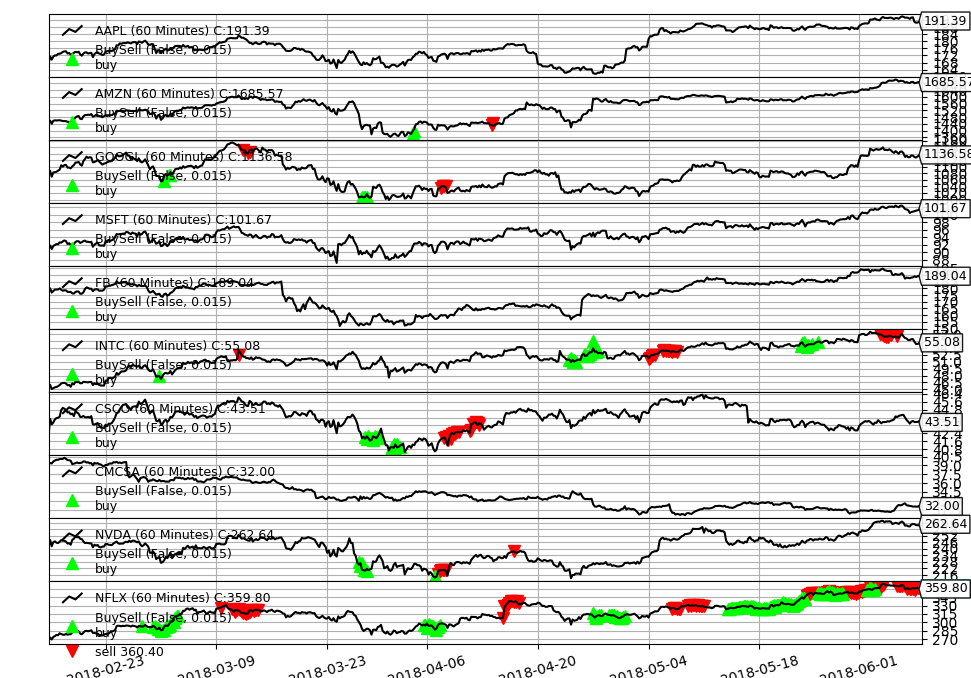

[[<Figure size 640x480 with 10 Axes>]]

In [8]:
cerebro.plot(volume=False)

In [ ]:
## MARKET PERFORMANCE:
class BuyAndHold(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datetime.datetime().strftime('%Y-%m-%d %H:%M:%S')
        print('%s, %s' % (dt, txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
      
    def __init__(self):
        return

    def next(self): 
        for i, d in enumerate(self.datas):
            self.buy(data = d, size=1)                


init_value = 3670.0 #Correct value to buy one stock a the beginning
init_value = 100000

for (init, finish) in TREND_WINDOWs:
    print('\n====================  trend: ',init,' ',finish, ' ==================== \n')
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(init_value)
    cerebro.broker.setcommission(commission=0.0001)
    predictions = pd.read_csv('testPredictions/AllTickers_'+str(init)+'_'+str(finish)+'.csv', index_col = 0)
    dates_test = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in predictions.index]
    for ticker in tickers:
        data = bt.feeds.GenericCSVData(
                    dataname='/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv',
                    name=ticker,
                    timeframe = bt.TimeFrame.Minutes, 
                    compression = 60,
                    datetime=1,open=2,high=3,low=4,close=5,volume=6,openinterest=-1,
                    fromdate=dates_test[0],
                    todate=dates_test[-1]+timedelta(minutes=1),
                    reverse=False)
        cerebro.adddata(data)
        
    cerebro.addstrategy(BuyAndHold)
    cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
    print('Starting Portfolio Value: %.2f' % init_value)
    strategy = cerebro.run()[0]
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f \nGain: %.2f' % (final_value, final_value/init_value - 1))